In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import fsolve

from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
from os import listdir
from os.path import isfile, join

import sys
from tqdm import tqdm
from numba import njit

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)


        Use get instead. [ligo.skymap.postprocess.cosmology]


In [13]:
def get_ename(fname, verbose=True):

        if len(fname.split('/')[-1].split('_')) <= 2:    #Same as before since certain names contain a "_"
            event_name = fname.split('/')[-1].split('_')[0]
        elif len(fname.split('/')[-1].split('_')) > 2:
            event_name = fname.split('/')[-1].split('_')[0]+'_'+fname.split('/')[-1].split('_')[1]
        else:
            raise ValueError('Could not set event name. Got fname= %s'%fname)
        if verbose:
            print('-- %s' %event_name)
        return event_name
    
def find_ra_dec(nside, pix):
        '''
        input:  pixel ra dec in degrees
        output: (ra, dec) of pixel center in degrees, with nside given by that of the skymap 
        '''
        theta, phi =find_theta_phi(nside,pix)
        ra, dec = ra_dec_from_th_phi(theta, phi)
        return ra, dec    
    
def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def find_theta_phi(nside, pix):
        '''
        input:  pixel
        output: (theta, phi)of pixel center in rad, with nside given by that of the skymap 
        '''
        return hp.pix2ang(nside, pix, nest=True)
    
def _read_O3( fname, convert_nested=True):
        
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        event_name = get_ename(fname, verbose=True)
        print('Event: %s' %event_name)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            p_posterior = hp.reorder(skymap[0],n2r=True)
            mu = hp.reorder(skymap[1],n2r=True)
            sigma = hp.reorder(skymap[2],n2r=True)
            posteriorNorm = hp.reorder(skymap[3],n2r=True)
            print('convertito da nested a ring')
            mu_avr=np.average(mu,weights=p_posterior)
            print('average luminosity distance={} Mpc'.format(mu_avr))
            sig_avr=np.average(sigma,weights=p_posterior)
            print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
            Norm_avr=np.average(posteriorNorm,weights=p_posterior)
            print('average posteriorNorm={} Mpc'.format(Norm_avr))
            z_gw=z_from_dL(mu_avr)
        else:
            p_posterior= skymap[0]
            mu= skymap[1]
            sigma = skymap[2]
            posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
        print('Theta={}, Phi={}'.format(theta, phi))
        ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
        print('Right Ascension={}, Declination={}'.format(ra, dec))
        #print(metadata)
        #dl=metadata['distmean']
        #std=metadata['diststd']
        #z=cosmoglob.H(0).value*dl/clight
        #sigz=cosmoglob.H(0).value*std/clight
        #print('dL={}Mpc, std={}Mpc'.format(dl,std))
        #print('z={}, delta_z={}'.format(z,sigz))
        #print('\n')
        head = None
def z_from_dL(dL_GW_val):
    '''
    Returns redshift for a given luminosity distance dL_GW_val (in Mpc)
    
    Input:
        - dL_GW_val luminosity dist in Mpc
        - H0
        - Xi0: float. Value of Xi_0
        - n: float. Value of n

    '''   
    #print(cosmo.H0)
    func = lambda z : cosmoflag.luminosity_distance(z).value - dL_GW_val
    z = fsolve(func, 1)
    return z[0]

def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.77)
    return z[0]

def mygaussint(prov_mu,prov_sigma,rho=1):
    first=np.exp(-(prov_mu**2)/(2*prov_sigma**2))*prov_mu*rho*prov_sigma/np.sqrt(2*np.pi)
    factor=0.5*rho*(prov_mu**2+prov_sigma**2)
    second=(1+scipy.special.erf(prov_mu/(np.sqrt(2)*prov_sigma)))
    ret=first+factor*second
    return ret
#@njit
def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=hp.ang2vec(mux,muy)
    #meanvec=np.asarray((1,mux,muy))
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=hp.ang2vec(x,y)
    #var=np.asarray((1,x,y))
    #norm=np.sqrt(np.dot(var,var))
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret

def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

In [110]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/Hold_O3/'
os.chdir(GW_data_path)
#all_event=os.listdir()

  # Function to exploit, find how to localise an event and produce a proxy one. 
   def _read_O3(self, fname, convert_nested=True):
        
   skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        self.event_name = get_ename(fname, verbose=self.verbose)
        if self.verbose:
                print('\nEvent: %s' %self.event_name)
                #Raul: prints for control
                print('Delta=%s. If delta=1, normal run '%delta)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            self.p_posterior = hp.reorder(skymap[0],n2r=True)
            self.mu = hp.reorder(skymap[1],n2r=True)
            self.sigma = hp.reorder(skymap[2],n2r=True)*delta
            self.posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            self.p_posterior= skymap[0]
            self.mu= skymap[1]
            self.sigma = skymap[2]*delta
            self.posteriorNorm= skymap[3]    

In [111]:
#Some files to look at 
filenames=['GW190814_PublicationSamples.fits'
           #,'GW190924_021846_PublicationSamples.fits'
           #,'GW190412_PublicationSamples.fits'
           #,'GW190915_235702_PublicationSamples.fits',
           #'GW190708_232457_PublicationSamples.fits',
           #'GW190421_213856_PublicationSamples.fits',
           #,'GW190527_092055_PublicationSamples.fits' 
           ]
########################## THIS GIVE US SOME INFO ######################################
#for name in filenames:
#    _read_O3(name)
########################################################################################
fname ='GW190814_PublicationSamples.fits'
alldl=[]
allsig=[]
for fname in filenames:
    print(fname)
    skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
    p_posterior= skymap[0]
    mu= skymap[1]
    sigma = skymap[2]
    posteriorNorm= skymap[3]        
    npix = len(p_posterior)
    print('npix={}'.format(npix))
    nside=hp.npix2nside(npix)
    print('nside={}'.format(nside))
    theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
    ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
    print('RA={},dec={},theta={},phi={}'.format(ra,dec,theta,phi))
    alldl.append(mu[np.argmax(p_posterior)])
    print('Dl={}'.format(mu[np.argmax(p_posterior)]))
    sig_avr=np.average(sigma,weights=p_posterior)
    allsig.append(sig_avr)
    print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
    #print(len(p_posterior))
#alldl=np.asarray(alldl)
#print(np.mean(alldl))

GW190814_PublicationSamples.fits
npix=12582912
nside=1024
RA=12.7001953125,dec=-24.87076339473571,theta=2.004873035517517,phi=0.22166022384947515
Dl=235.45665178530027
average luminosity distance Sigma=26.530261090991182 Mpc


In [5]:
sig_perc=[]
for i in range(len(alldl)):
    sig_perc.append(100*allsig[i]/alldl[i])
sig_perc=np.asarray(sig_perc[0:-1])
print(np.mean(sig_perc))

21.277833926793964


In [ ]:
my_theta,my_phi=hp.pix2ang(nside, np.argmax(p_posterior), nest=True)
vec = hp.ang2vec(my_theta, my_phi)
my_maxpix=hp.ang2pix(nside, my_theta, my_phi,nest=True)
maxpix=np.argmax(p_posterior)
print(maxpix,my_maxpix)

In [ ]:
print(vec)

In [ ]:
hp.mollview(p_posterior, title=fname,nest=True)

In [ ]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))

In [ ]:
_read_O3(fname)

In [ ]:
vec = hp.ang2vec(my_theta, my_phi)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
ipix_90 = hp.query_disc(nside=nside, vec=vec, radius=np.radians(radius_deg), nest=True)
m =np.zeros(len(p_posterior))
m[ipix_disc] = 1/len(ipix_disc)
hp.mollview(m, title="Gaussian Mask",nest=True)

In [ ]:
Mock_Area_deg=len(ipix_disc) * hp.nside2pixarea(nside, degrees=True)
Mock_Area_90_deg=len(ipix_90) *hp.nside2pixarea(nside, degrees=True)
print('99.9999% area is {} squared deg\n90% area is {} squared deg'.format(Mock_Area_deg,Mock_Area_90_deg))

In [ ]:
'''
https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)

Now we need to rescale the probability. We set the prob=0 ouside the circle
We assume that the renormalization is constant.
We crate a mask with our circle. Outside the mask p_posterior=0, the renormalization
constan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. 

If this works, than we will use a 2D Gaussian distribution for the probability

'''


In [ ]:
fname ='GW190708_232457_PublicationSamples.fits'
print(fname)
skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
nside=hp.npix2nside(npix)
hp.mollview(p_posterior, title=fname,nest=True)

In [ ]:
#saved_prob=np.zeros(len(p_posterior))
#saved_prob[ipix_disc]=p_posterior[ipix_disc]
#prob_to_write=np.zeros(len(p_posterior))
#alpha=1/np.sum(saved_prob)
#prob_to_write[ipix_disc]=alpha*saved_prob[ipix_disc]

In [ ]:
#print(np.sum(prob_to_write))

In [ ]:
#hp.mollview(prob_to_write, title="Mollview image NESTED",nest=True)

In [ ]:
#my_sky_tosave=(prob_to_write,skymap[1],sigma,posteriorNorm)
#my_sky_tosave=np.array([prob_to_write,mu,sigma,posteriorNorm])
#dat=Table([prob_to_write,mu,sigma,posteriorNorm],
#          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
#fits.write_sky_map('Amap.fits',dat, nest=True)

In [ ]:
#check result

In [ ]:
#my_data,my_meta=fits.read_sky_map("Amap.fits",nest=None, distances=True)
#print(my_meta)

In [ ]:
#hp.mollview(my_data[0], title="Mollview image NESTED",nest=True)

In [ ]:
#print(my_meta)

In [ ]:
#_read_O3('Amap.fits')

In [ ]:
temp_theta,temp_phi=find_theta_phi(nside,np.argmax(gaussmap))
temp_ra, temp_dec=find_ra_dec(nside,np.argmax(gaussmap))
print('GW221005 location: theta={}, phi={}, RA={}, DEC={}'.format(temp_theta,temp_phi,temp_ra,temp_dec))

In [ ]:
fname ='GW221900_PublicationSamples.fits'
my_data,my_meta=fits.read_sky_map(fname,nest=None, distances=True)

In [ ]:
my_prob=my_data[0]
my_mu=my_data[1]
my_sigma=my_data[2]
npix = len(my_prob)
nside=hp.npix2nside(npix)
#my_mu[np.isinf(my_mu)]=0
hp.mollview(my_prob, title=fname,nest=True)

In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.argmax(my_prob)
maxtheta,maxphi=hp.pix2ang(nside, 841536)
vicini=hp.get_all_neighbours(nside,maxtheta,maxphi)
print(maxtheta,maxphi)
print(vicini)

In [ ]:
for i in vicini:
    maxtheta,maxphi=hp.pix2ang(nside, i, nest=True)
    print(hp.get_all_neighbours(nside,maxtheta,maxphi,nest=True))

In [ ]:
if(np.isnan(my_prob).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isnan(my_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
    
if(np.isinf(my_prob).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
if(np.isinf(my_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

In [ ]:
credible_levels = find_greedy_credible_levels(gaussmap)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.sum(my_mu[0:3]*my_prob[0:3])

In [ ]:
len(my_mu)==len(my_prob)

# Automatic Map Creator 

z_min=0.7887375950813293, z_max=2.0129446983337402
ra_min=1.558116673550103e-05, ra_max=89.99999237060547
dec_min=2.9646462280652486e-06, dec_max=89.98294830322266
phi_min=2.7194266749575036e-07, phi_max=1.5707961320877075
theta_min=0.0002976218846182377, theta_max=1.570796275052059

In [ ]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [ ]:
nside=1024#512
npix = hp.nside2npix(nside)
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)

phi_min=0.0001
phi_max=1.5707961320877075
theta_min=0.0001976218846182377
theta_max=1.570796275052059
phi_start=phi_min+5*sigma_phi
phi_stop=phi_max-5*sigma_phi
step =5* sigma_phi
N=np.floor((phi_stop-phi_start)/step)
N=int(N)
#----------------------uniform in comoving DS-----------------------------
zlen=10
allredshift=np.zeros(zlen)
my_zmin=1.1
my_zmax=1.3
my_dcom_min=cosmoflag.comoving_distance(my_zmin).value
my_dcom_max=cosmoflag.comoving_distance(my_zmax).value
alldcom=np.linspace(my_dcom_min,my_dcom_max,zlen)
for i in range(zlen):
    allredshift[i]=z_from_dcom(alldcom[i])
#-------------------------------------------------------------------------
print('Sigma_theta={}, Sigma_phi={}'.format(sigma_theta,sigma_phi))
print('Sigma_theta={}°, Sigma_phi={}°'.format(np.rad2deg(sigma_theta)
                                              ,np.rad2deg(sigma_phi)))
print(step, N)
allphi=np.arange(0,N)*step+phi_start


truethetamin=theta_min+6*sigma_theta
truethetamax=theta_max-6*sigma_theta
M=np.floor((truethetamax-truethetamin)/step)
M=int(M)
alltheta=np.arange(0,M)*step+truethetamin

print('N={},M={}, NxM={}'.format(N,M,N*M))


#name='GW33xxxx_datasheet.txt'
#file= open(name,'w')
#my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
#file.writelines(my_header)
#file.close()

In [ ]:
'''Use this when phi and theta both changes'''
for j in tqdm(range(M)):
    for k in range(N):
        numevent=int(320000)+k+j*N
        fname='GW'+str(numevent)+'_PublicationSamples.fits'
        index=k%zlen
        zref=allredshift[index]
        DS_phi=allphi[k]
        DS_theta=alltheta[j]
        vec = hp.ang2vec(DS_theta, DS_phi)
        ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
        #print(DS_theta,DS_phi)
        if fisher==1:
            gaussmap =np.zeros(npix,dtype=np.float128)
        else:
            gaussmap =np.zeros(npix)
        mod_mu=np.zeros(len(gaussmap))
        mod_sigma=np.zeros(len(gaussmap))
        mod_postnorm=np.zeros(len(gaussmap))
        theta_arr=np.zeros(len(gaussmap))
        phi_arr=np.zeros(len(gaussmap))
        gauss64 =np.zeros(len(gaussmap),dtype=np.float128)

        dlref=cosmoflag.luminosity_distance(zref).value
        dlsig=0.1*dlref
        #print(zref,dlref)
        line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
             str(dlsig)+'\t',str(sigma_phi)+'\n']

        for i in ipix_disc:
            theta,phi=hp.pix2ang(nside,i, nest=True)
            theta_arr[i]=theta
            phi_arr[i]=phi
            #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
            gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
            mod_mu[i]=dlref#uncorr_gauss(theta,phi)
            mod_sigma[i]=dlsig
            mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
        gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
        #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
        #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]
        
        gauss64=np.float64(gaussmap)
        dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
              names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
        fits.write_sky_map(fname,dat, nest=True)
        with open(name,'a') as f:
            f.writelines(line)

# Generation by extraction from a Galaxy Catalogue

In [16]:
#----------------Load the catalogue---------------------
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
galcat = pd.read_csv('genova_uniform_samezasminimal.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
galcat.columns=colnames
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)


In [17]:
#----------------------select random hosts ----------------------------------
zmin=0.95
zmax=1.05
Numb_of_DS=300
source=galcat[galcat['z']>=zmin]
source=source[source['z']<=zmax]
nside=256#1024
npix=hp.nside2npix(nside)
#Best would be to remove the selected one, make them host and then add those again, 
#since we are converting coordinates
#pd.concat([df1, df2, df2]).drop_duplicates(keep=False)

DS_z=np.asarray(source['z'])
DS_dl=np.asarray(source['dl'])
DS_RA=np.asarray(source['right_ascension_degrees'])
DS_DEC=np.asarray(source['declination_degrees'])

phi_gals=np.deg2rad(DS_RA)
theta_gals = (0.5 * np.pi - np.deg2rad(DS_DEC))
#ra_gals=ra = np.rad2deg(phi_gals)
#dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

#checkRA=DS_RA-ra_gals
#chackDEC=DS_DEC-dec_gals
#print(checkRA)
#print(chackDEC)
fisher=0
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    #conc=50
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)


theta_min=np.min(theta_gals)
theta_max=np.max(theta_gals)
phi_min=np.min(phi_gals)
phi_max=np.max(phi_gals)

truethetamin=theta_min+10*sigma_theta
truethetamax=theta_max-10*sigma_theta
truephimin=phi_min+10*sigma_phi
truephimax=phi_max-10*sigma_phi

trueRA_min=np.rad2deg(truephimin)
trueRA_max=np.rad2deg(truephimax)
trueDECmin=np.rad2deg(-truethetamax+0.5*np.pi)
trueDECmax=np.rad2deg(-truethetamin+0.5*np.pi)

source=source[source['right_ascension_degrees']>=trueRA_min]
source=source[source['right_ascension_degrees']<=trueRA_max]
source=source[source['declination_degrees']>=trueDECmin]
source=source[source['declination_degrees']<=trueDECmax]

cutted=source.sample(Numb_of_DS)

DS_z=np.asarray(cutted['z'])
DS_dl=np.asarray(cutted['dl'])
DS_RA=np.asarray(cutted['right_ascension_degrees'])
DS_DEC=np.asarray(cutted['declination_degrees'])

phi_gals=np.deg2rad(DS_RA)
theta_gals = (0.5 * np.pi - np.deg2rad(DS_DEC))


#print(trueDECmin,trueDECmax,trueRA_min,trueRA_max)

#-------------------DATASHEET--------------------------------------
write=1
if write==1:
    name='GW99xxxx_datasheet.txt'
    file= open(name,'w')
    my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
    file.writelines(my_header)
    file.close()
print(nside,npix) 

256 786432


In [18]:
#print(((phi_gals>=truephimin).sum()==len(phi_gals)).astype(np.int))
#print(((phi_gals<=truephimax).sum()==len(phi_gals)).astype(np.int))

#print(((theta_gals>=truethetamin).sum()==len(theta_gals)).astype(np.int))
#print(((theta_gals<=truethetamax).sum()==len(theta_gals)).astype(np.int))
#print(truethetamin,truethetamax,truephimin,truephimax)
#print(trueDECmin,trueDECmax,trueRA_min,trueRA_max)
#print((truethetamin-theta_min)/sigma_theta)

In [19]:
#j=0
#test_DS_z=np.asarray(galcat['z'])
#test_DS_dl=np.asarray(galcat['dl'])
#test_DS_RA=np.asarray(galcat['right_ascension_degrees'])
#test_DS_DEC=np.asarray(galcat['declination_degrees'])
#for k in range(len(DS_z)):
#    idx=np.where(test_DS_z==DS_z[k])
#    if ((test_DS_dl[idx]==DS_dl[k])*(test_DS_RA[idx]==DS_RA[k])*(test_DS_DEC[idx]==DS_DEC[k])):
#        j=j+1
#        print('DS {} is in the full cat'.format(k))
#print(j)

In [21]:
#--------------------Maps Generations-------------------------------
'''Use this when phi and theta both changes'''
for i in tqdm(range(Numb_of_DS)):
    numevent=int(990000)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=DS_z[i]
    DS_phi=phi_gals[i]
    DS_theta=theta_gals[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(npix,dtype=np.float128)
    else:
        gaussmap =np.zeros(npix)
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(gaussmap))
    mod_sigma=np.zeros(len(gaussmap))
    mod_postnorm=np.zeros(len(gaussmap))
    theta_arr=np.zeros(len(gaussmap))
    phi_arr=np.zeros(len(gaussmap))
    gauss64 =np.zeros(len(gaussmap),dtype=np.float128)

    dlref=DS_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.1*dlref
    #print(zref,dlref)
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        gaussmap[i]=1#sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        #gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1
    #gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    if write==1:
        fits.write_sky_map(fname,dat, nest=True)
        with open(name,'a') as f:
            f.writelines(line)
    #print(nside,npix)

100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.26it/s]


In [142]:
nside=256
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)
print(sigma_deg,10*sigma_deg)

Approximate resolution at NSIDE 256 is 0.23 deg
0.8410441740067199 8.4104417400672


# Read Maps, Change sigma and/or Gauss displace
Those changes will not appear in the datasheet, so attention

In [3]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
all_files=os.listdir()
GWs=[]
for i in range(len(all_files)):
    if 'GW99000' in all_files[i]:
        GWs.append(all_files[i])
GWs=list(dict.fromkeys(GWs))
del (all_files)
print(len(GWs))
print(GWs)

10
['GW990004_PublicationSamples.fits', 'GW990009_PublicationSamples.fits', 'GW990000_PublicationSamples.fits', 'GW990005_PublicationSamples.fits', 'GW990008_PublicationSamples.fits', 'GW990001_PublicationSamples.fits', 'GW990003_PublicationSamples.fits', 'GW990007_PublicationSamples.fits', 'GW990002_PublicationSamples.fits', 'GW990006_PublicationSamples.fits']


In [4]:
skymap, metadata = fits.read_sky_map(GWs[0], nest=None, distances=True)
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
nside=hp.npix2nside(npix)


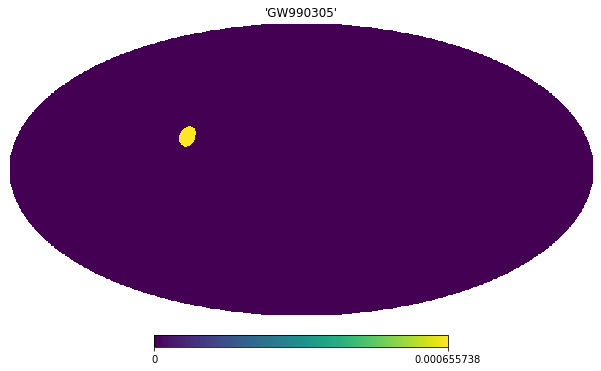

In [5]:
hp.mollview(p_posterior, title=fname,nest=True)

In [6]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))
print(nside)

Ligo area_deg 99% is 79.15588191397816
Ligo area_deg 90% is 71.96943007685755 
256


In [15]:
#my_theta,my_phi=find_theta_phi(nside,np.argmax(p_posterior))
#my_ra, my_dec=find_ra_dec(nside,np.argmax(p_posterior))
#print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(mu,weights=p_posterior)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(sigma,weights=p_posterior)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
Norm_avr=np.average(posteriorNorm,weights=p_posterior)
print('average posteriorNorm={}'.format(Norm_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

average luminosity distance=7248.71753140479 Mpc
average luminosity distance Sigma=724.8717531404792 Mpc
average posteriorNorm=1.0
redshift=1.0499178486779905, in flagship cosmology
comoving distance=3536.101476495533


In [14]:
_read_O3(GWs[0])

-- GW990004
Event: GW990004
convertito da nested a ring
average luminosity distance=7248.71753140479 Mpc
average luminosity distance Sigma=724.8717531404791 Mpc
average posteriorNorm=1.0 Mpc
Theta=0.605639039248128, Phi=5.2877876348523385
Right Ascension=302.96791443850265, Declination=55.299439142724246


In [124]:
for fname in tqdm(GWs):
    #print(fname)
    skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
    p_posterior= skymap[0]
    mu= skymap[1]
    sigma = skymap[2]
    posteriorNorm= skymap[3]        
    npix = len(p_posterior)
    nside=hp.npix2nside(npix)
    #alldl.append(mu[np.argmax(p_posterior)])
    #print('Dl={}'.format(mu[np.argmax(p_posterior)]))
    sigma=mu*0.1
    #sig=np.average(sigma,weights=p_posterior)
    #dl=np.average(mu,weights=p_posterior)
    #newdl=np.random.normal(dl,sig)
    #scale=newdl/dl
    #new_mu=scale*mu
    #new_sigma=new_mu*0.1
    #sig_avr=np.average(sigma,weights=p_posterior)
    #print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
    dat=Table([p_posterior,mu,sigma,posteriorNorm],
             names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)

100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]


In [85]:
print(sigma[sigma>0])
np.shape(sigma)
print(len(p_posterior),len(sigma))



[66.56731562 66.56731562 66.56731562 ... 66.56731562 66.56731562
 66.56731562]
3145728 3145728


# List Creator to config.py

In [2]:
names=[]

for i in range(306):
    numevent=int(990000)+i
    fname="'"+'GW'+str(numevent)+"'"
    names.append(fname)
    if (i % 38== 0)&(i>0):
        to_print=','.join(names)
        print('{}'.format(to_print))
        names=[]

'GW990000','GW990001','GW990002','GW990003','GW990004','GW990005','GW990006','GW990007','GW990008','GW990009','GW990010','GW990011','GW990012','GW990013','GW990014','GW990015','GW990016','GW990017','GW990018','GW990019','GW990020','GW990021','GW990022','GW990023','GW990024','GW990025','GW990026','GW990027','GW990028','GW990029','GW990030','GW990031','GW990032','GW990033','GW990034','GW990035','GW990036','GW990037','GW990038'
'GW990039','GW990040','GW990041','GW990042','GW990043','GW990044','GW990045','GW990046','GW990047','GW990048','GW990049','GW990050','GW990051','GW990052','GW990053','GW990054','GW990055','GW990056','GW990057','GW990058','GW990059','GW990060','GW990061','GW990062','GW990063','GW990064','GW990065','GW990066','GW990067','GW990068','GW990069','GW990070','GW990071','GW990072','GW990073','GW990074','GW990075','GW990076'
'GW990077','GW990078','GW990079','GW990080','GW990081','GW990082','GW990083','GW990084','GW990085','GW990086','GW990087','GW990088','GW990089','GW990090'

In [33]:
names=[]

for i in range():
    numevent=int(970000)+i
    fname="'"+'GW'+str(numevent)+"'"
    names.append(fname)
    to_print=','.join(names)
print('{}'.format(to_print))

'GW970000','GW970001','GW970002','GW970003','GW970004','GW970005','GW970006','GW970007','GW970008','GW970009','GW970010','GW970011','GW970012','GW970013','GW970014','GW970015','GW970016','GW970017','GW970018','GW970019','GW970020','GW970021','GW970022','GW970023','GW970024','GW970025','GW970026','GW970027','GW970028','GW970029','GW970030','GW970031','GW970032','GW970033','GW970034','GW970035','GW970036','GW970037','GW970038','GW970039'


In [ ]:
names=[]

for i in range(50):
    numevent=int(37)+i
    fname="'"+'GW'+str(numevent)+'0'+"'"
    names.append(fname)
    to_print=','.join(names)
print('{}'.format(to_print))

# Reset
those lines are used to reset the maps to the Datasheet state

In [ ]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [ ]:
#-------------------DATASHEET--------------------------------------
name='GW31xxxx_datasheet.txt'
#file= open(name,'w')
#my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
#file.writelines(my_header)
#file.close()
with open(name,'r') as f:
    next(f)
    lines=f.readlines()
    GWs_dl=[]
    GWs_theta=[]
    GWs_phi=[]
    GWs_z=[]
    GWs_deltadl=[]
    for x in lines:
        GWs_dl.append(float(x.split('\t')[1]))
        GWs_theta.append(float(x.split('\t')[2]))
        GWs_phi.append(float(x.split('\t')[3]))
        GWs_z.append(float(x.split('\t')[4]))
        GWs_deltadl.append(float(x.split('\t')[5]))
    #for i in range(len(GW_z)):

GWs_dl=np.asarray(GWs_dl)
GWs_theta=np.asarray(GWs_theta)
GWs_phi=np.asarray(GWs_phi)
GWs_z=np.asarray(GWs_z)
GWs_deltadl=np.asarray(GWs_deltadl)

In [ ]:
for i in tqdm(range(len(GWs_dl))):
    numevent=int(310000)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=GWs_z[i]
    DS_phi=GWs_phi[i]
    DS_theta=GWs_theta[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    else:
        gaussmap =np.zeros(len(p_posterior))
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)

    dlref=GWs_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    #print(zref,dlref)
    #line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
    #     str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
    #with open(name,'a') as f:
    #    f.writelines(line)

In [ ]:
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)

phi_min=0.0001
phi_max=1.5707961320877075
theta_min=0.0001976218846182377
theta_max=1.570796275052059
phi_start=phi_min+5*sigma_phi
phi_stop=phi_max-5*sigma_phi
step =5* sigma_phi
N=np.floor((phi_stop-phi_start)/step)
N=int(N)
#----------------------uniform in comoving DS-----------------------------
zlen=10
allredshift=np.zeros(zlen)
my_zmin=1.1
my_zmax=1.3
my_dcom_min=cosmoflag.comoving_distance(my_zmin).value
my_dcom_max=cosmoflag.comoving_distance(my_zmax).value
alldcom=np.linspace(my_dcom_min,my_dcom_max,zlen)
for i in range(zlen):
    allredshift[i]=z_from_dcom(alldcom[i])
#-------------------------------------------------------------------------
print('Sigma_theta={}, Sigma_phi={}'.format(sigma_theta,sigma_phi))
print('Sigma_theta={}°, Sigma_phi={}°'.format(np.rad2deg(sigma_theta)
                                              ,np.rad2deg(sigma_phi)))
print(step, N)
allphi=np.arange(0,N)*step+phi_start


truethetamin=theta_min+6*sigma_theta
truethetamax=theta_max-6*sigma_theta
M=np.floor((truethetamax-truethetamin)/step)
M=int(M)
alltheta=np.arange(0,M)*step+truethetamin


In [ ]:
allredshift=np.linspace(1.1,1.3,10)
fisher=1
if fisher==1:
    radius_deg= np.sqrt(1000/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    #conc=100
    #sigma_phi=np.sqrt(1/conc)
    #sigma_theta=sigma_phi
    radius_rad=np.radians(circle_deg)
for k in tqdm(range(1)):
    numevent=int(220000)+k
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=allredshift[k]
    #print(zref)
    DS_phi=np.pi/4
    DS_theta=np.pi/4
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))

    dlref=cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\n']
    
    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        #mod_postnorm[i]=1/(mygaussint(mod_mu[i],mod_sigma[i]))
    #gaussmap[ipix_disc] = 1/len(ipix_disc)
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=1/(len(ipix_disc))
    mod_postnorm[ipix_disc]=1
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)
    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    #fits.write_sky_map(fname,dat, nest=True)
   # with open(name,'a') as f:
    #    f.writelines(line)

In [ ]:
hp.mollview(gauss64, title=fname,nest=True)

# Map for Minimal Example

In [ ]:
#----------------Load the catalogue---------------------
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
galcat = pd.read_csv('genova_uniform_samezasminimal.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
galcat.columns=colnames
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [ ]:
phi_min=0
phi_max=phi_min+5.5*sigma_phi
theta_min=0
theta_max=theta_min+5.5*sigma_theta#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
DS_phi=(phi_max-phi_min)/2
DS_theta=(theta_max-theta_min)/2

In [ ]:
#----------------------select random hosts ----------------------------------
zmin=0.1
zmax=0.3
#ra_min=np.rad2deg(DS_phi-1*sigma_phi)
#ra_max=np.rad2deg(DS_phi+1*sigma_phi)

#dec_max=np.rad2deg(0.5 * np.pi - (DS_theta-1*sigma_theta))
#dec_min=np.rad2deg(0.5 * np.pi - (DS_theta+1*sigma_theta))

Numb_of_DS=40
source=galcat[galcat['z']>=zmin]
source=source[source['z']<=zmax]
#source=source[source['declination_degrees']<=dec_max]
#source=source[source['declination_degrees']>=dec_min]
#source=source[source['right_ascension_degrees']<=ra_max]
#source=source[source['right_ascension_degrees']>=ra_min]

source=source.sample(n=Numb_of_DS)


#Best would be to remove the selected one, make them host and then add those again, 
#since we are converting coordinates
#pd.concat([df1, df2, df2]).drop_duplicates(keep=False)

DS_z=np.asarray(source['z'])
DS_dl=np.asarray(source['dl'])
DS_RA=np.asarray(source['right_ascension_degrees'])
DS_DEC=np.asarray(source['declination_degrees'])

phi_gals=np.deg2rad(DS_RA)
theta_gals = (0.5 * np.pi - np.deg2rad(DS_DEC))
#ra_gals=ra = np.rad2deg(phi_gals)
#dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

#checkRA=DS_RA-ra_gals
#chackDEC=DS_DEC-dec_gals
#print(checkRA)
#print(chackDEC)
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)
#-------------------DATASHEET--------------------------------------
name='GW98xxxx_datasheet.txt'
file= open(name,'w')
my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
file.writelines(my_header)
file.close()

In [ ]:
#--------------------Maps Generations-------------------------------
'''Use this when phi and theta both changes'''
for i in tqdm(range(Numb_of_DS)):
    numevent=int(980000)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=DS_z[i]
    DS_phi=phi_gals[i]
    DS_theta=theta_gals[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    else:
        gaussmap =np.zeros(len(p_posterior))
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)

    dlref=DS_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.1*dlref
    #print(zref,dlref)
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
    with open(name,'a') as f:
        f.writelines(line)

# Testing the distributions

In [ ]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [193]:
fname ='GW960000_PublicationSamples.fits'
alldl=[]
allsig=[]
print(fname)
skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
print('npix={}'.format(npix))
nside=hp.npix2nside(npix)
print('nside={}'.format(nside))
theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
print('RA={},dec={},theta={},phi={}'.format(ra,dec,theta,phi))
alldl.append(mu[np.argmax(p_posterior)])
print('Dl={}'.format(mu[np.argmax(p_posterior)]))
sig_avr=np.average(sigma,weights=p_posterior)
allsig.append(sig_avr)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
allni=np.average(posteriorNorm,weights=p_posterior)
print('average N_i={}'.format(allni))
#print(len(p_posterior))
#alldl=np.asarray(alldl)
#print(np.mean(alldl))

GW960000_PublicationSamples.fits
npix=786432
nside=256
RA=75.625,dec=76.81353334098655,theta=0.23014725990424112,phi=1.3199052468207118
Dl=7089.601208602169
average luminosity distance Sigma=708.960120860217 Mpc
average N_i=1.0
